# Importing libraries, data etc.





In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.math import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from google.colab import drive
drive.mount('/content/drive')

gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU 0: Tesla T4 (UUID: GPU-8cc52b3f-a716-5584-7228-b9c8a2753f11)


In [15]:
#Function to create a model

def create_model(input_shape,
                 n_classes,
                 units_LSTM=[256,128,64],
                 units_Dense=[64,32],
                 dropout_LSTM=0.2,
                 dropout_Dense=0.15,
                 learning_rate=0.001,
                 ):
    """
    Creates a LSTM model with 3 LSTM layers and 3 dense layers (the last one is output layer)
    """
    #assert units_LSTM[2] == units_Dense[0], "Dimensions of 3rd LSTM Layer and 1st Dense Layer should fit"

    model = keras.Sequential()
    # 2 LSTM layers
    model.add(keras.layers.LSTM(units=units_LSTM[0],
                                input_shape=input_shape,
                                return_sequences=True,
                                dropout=dropout_LSTM
                                ))

    model.add(keras.layers.LSTM(units=units_LSTM[1],
                                input_shape=input_shape,
                                return_sequences=True,
                                dropout=dropout_LSTM
                                ))

    model.add(keras.layers.LSTM(units_LSTM[2]))

    # dense layers
    model.add(keras.layers.Dense(units=units_Dense[0], activation='relu'))
    model.add(keras.layers.Dropout(dropout_Dense))

    model.add(keras.layers.Dense(units_Dense[1], activation='relu'))
    model.add(keras.layers.Dropout(dropout_Dense))

    # output layer
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    #compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
X_raw=np.load('/content/drive/MyDrive/Pro2/fet.npy')
y_raw=pd.read_csv('/content/drive/MyDrive/Pro2/y_raw_clean.csv')

In [10]:
noice_egz = ["zero", "one","two", "three",
             "four", "five", "six", "seven",
             "eight", "nine","bed", "bird",
             "cat", "dog", "happy", "house",
             "marvin", "sheila", "tree", "wow"]

y_raw['label'] = np.where(y_raw['label'].isin(noice_egz), "unknown", y_raw['label'])
encoded = pd.read_csv('/content/drive/MyDrive/Pro2/models/label_encodings.csv')

y_all = y_raw.merge(encoded, left_on='label', right_on='name',how="left")['index']

# Training the model with a train-test split

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X_raw,y_all,stratify=y_all,test_size=0.25)

In [18]:
input_shape = (X_train.shape[1], X_train.shape[2]) # 20,98
n_classes=len(np.unique(y_train)) #12

model=create_model(input_shape=input_shape,
                   n_classes=n_classes,
                   units_LSTM=[256,128,70],
                   units_Dense=[64,32],
                   dropout_LSTM=0.2,
                   dropout_Dense=0.15,
                   learning_rate=0.001)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 256)           363520    
                                                                 
 lstm_7 (LSTM)               (None, 20, 128)           197120    
                                                                 
 lstm_8 (LSTM)               (None, 70)                55720     
                                                                 
 dense_6 (Dense)             (None, 64)                4544      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [19]:
callbacks=[
           ReduceLROnPlateau(
               monitor='val_loss',
               factor=0.5,
               patience=3,
               mode='auto',
               cooldown=2,
               min_lr=1e-5),
           EarlyStopping(
               monitor="val_loss",
               min_delta=1e-5,
               patience=6,
               mode="auto",
               restore_best_weights=True),
           ModelCheckpoint('/content/drive/MyDrive/Pro2/models/grid_search/my_model.hdf5',
               monitor='val_loss',
               save_best_only=True,
               save_freq='epoch')
]
    
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, callbacks=callbacks,epochs=1000)

Epoch 1/1000
1527/1527 [==============================] - 21s 11ms/step - loss: 1.5033 - accuracy: 0.6315 - val_loss: 1.3361 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 2/1000
1527/1527 [==============================] - 16s 10ms/step - loss: 1.2583 - accuracy: 0.6499 - val_loss: 1.0548 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 3/1000
1527/1527 [==============================] - 16s 10ms/step - loss: 1.0312 - accuracy: 0.6797 - val_loss: 0.8600 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 4/1000
1527/1527 [==============================] - 16s 10ms/step - loss: 0.8994 - accuracy: 0.7160 - val_loss: 0.7769 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 5/1000
1527/1527 [==============================] - 16s 10ms/step - loss: 0.8159 - accuracy: 0.7403 - val_loss: 0.6885 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 6/1000
1527/1527 [==============================] - 16s 10ms/step - loss: 0.7554 - accuracy: 0.7584 - val_loss: 0.6797 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 7/1000
1527/1527 [==========

## Confussion matrix and balanced accuracy score


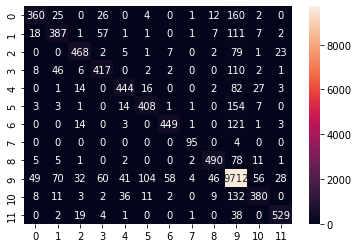

0.7685161794664687

In [20]:
y_pred=model.predict(X_test).argmax(axis=1)
conf_matrix=confusion_matrix(labels=y_test,predictions=y_pred)
plt.plot(figsize=(20,18))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()
balanced_accuracy_score(y_test, y_pred)

# Training the model on the whole set.

In [21]:
input_shape = (X_raw.shape[1], X_raw.shape[2]) # 20,98
n_classes=len(np.unique(y_all)) #12

model=create_model(input_shape=input_shape,
                   n_classes=n_classes,
                   units_LSTM=[256,128,64],
                   units_Dense=[64,32],
                   dropout_LSTM=0.2,
                   dropout_Dense=0.15,
                   learning_rate=0.001)

In [22]:
callbacks=[
           ReduceLROnPlateau(
               monitor='loss',
               min_delta=0.1,
               factor=0.5,
               patience=3,
               mode='auto',
               cooldown=2,
               min_lr=1e-5),
          #  EarlyStopping(
          #      monitor="val_loss",
          #      min_delta=1e-5,
          #      patience=6,
          #      mode="auto",
          #      restore_best_weights=True),
           ModelCheckpoint('/content/drive/MyDrive/Pro2/models/model_whole.hdf5',
               monitor='loss',
               save_best_only=True,
               save_freq='epoch')
]
    
history = model.fit(X_raw, y_all, validation_data=(X_raw, y_all), batch_size=32, callbacks=callbacks,epochs=40)

Epoch 1/40
2035/2035 [==============================] - 32s 14ms/step - loss: 1.4466 - accuracy: 0.6330 - val_loss: 1.2259 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 2/40
2035/2035 [==============================] - 24s 12ms/step - loss: 1.1438 - accuracy: 0.6594 - val_loss: 0.8866 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 3/40
2035/2035 [==============================] - 23s 11ms/step - loss: 0.9376 - accuracy: 0.7032 - val_loss: 0.7289 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 4/40
2035/2035 [==============================] - 23s 11ms/step - loss: 0.8248 - accuracy: 0.7370 - val_loss: 0.6113 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 5/40
2035/2035 [==============================] - 23s 11ms/step - loss: 0.7532 - accuracy: 0.7580 - val_loss: 0.5835 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 6/40
2035/2035 [==============================] - 27s 13ms/step - loss: 0.6995 - accuracy: 0.7757 - val_loss: 0.5168 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 7/40
2035/2035 [========================

## Confussion matrix and balanced accuracy score

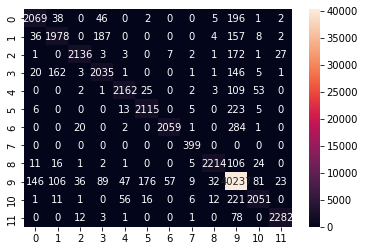

0.907548753817903

In [23]:
y_pred=model.predict(X_raw).argmax(axis=1)
conf_matrix=confusion_matrix(labels=y_all,predictions=y_pred)
plt.plot(figsize=(20,18))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()
balanced_accuracy_score(y_all, y_pred)